<a href="https://colab.research.google.com/github/MattiaEmma2022/MattiaEmma2022/blob/main/Important_sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# -- Use the following line in Google Colab deleting the hash
! pip install -q bilby==2.0.1 matplotlib==3.6.0 dynesty==2.1.0 corner==2.2.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 38.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.7/105.7 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 833.0/833.0 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 2.0 MB/s eta 0:00:00


In [3]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import bilby
import corner
import pickle
import scipy.stats

Define the important functions to include in the routine for the sampler:

In [4]:

def model_Ms(time, freq, alpha):
    return np.exp(-(time/alpha)**2) * np.sin(2 * np.pi * freq * time)

def log_likelihood_Ms(time, yobs, freq, alpha, sigma=0.1):
    prediction = model_Ms(time, freq, alpha)
    res = yobs - prediction 
    logl = -0.5 * ((res/sigma)**2) + np.log(2 * np.pi * sigma**2)
    # Sum over all log_likelihoods (axis=0)
    return np.sum(logl, axis=0)    
def create_data(time,freq,alpha,sigma):
  yobs_new=model_Ms(time, freq, alpha)
  noise=np.random.normal(0,sigma,np.size(time))
  yobs=yobs_new+noise
  return yobs

In [5]:
def log_prior_Ms(freq, alpha):
    """ Calculate the log prior under the Ms model
    
    Parameters
    ----------
    freq: array or float
        The frequency at which to calculate the prior
    alpha: array or float
        The alpha at which to calculate the prior
        
    Returns
    -------
    log_prior: array
        The log_prior calculated for all freq, alpha samples
    """
    # Convert freq, alpha to numpy arrays
    freq = np.atleast_1d(freq)
    alpha = np.atleast_1d(alpha)
    
    # Apply Uniform priors: calculate idxs of array where f, alpha in range
    f_min = 0
    f_max = 5
    f_idxs = (freq > f_min) * (freq < f_max)
    
    alpha_min = 0
    alpha_max = 1
    alpha_idxs = (alpha > alpha_min) * (alpha < alpha_max)
    
    idxs = alpha_idxs * f_idxs
    
    log_prior_volume = np.log(1/(f_max - f_min) * (1 / (alpha_max - alpha_min)))
    
    log_prior = np.zeros_like(freq)
    log_prior[idxs] = log_prior_volume
    log_prior[~idxs] = -np.inf
    return log_prior

Sampler routine:

In [16]:
def routine(time,freq,alpha,N):
  yobs=create_data(time,freq,alpha,0.2)
  # Draw 10000 samples 
  freq_samples = np.random.normal(freq,0.06,N)
  alpha_samples = np.random.normal(alpha,0.01,N)

  #Make time a 2D array to enable broadcasting across the samples
  time_array = time[:, np.newaxis]
  yobs_array = yobs[:, np.newaxis]
  # Calculate the log_likelihood and log_prior for all samples
  log_likelihood_vals = log_likelihood_Ms(time_array, yobs_array, freq_samples, alpha_samples)
  log_prior_vals = log_prior_Ms(freq_samples, alpha_samples)
  log_posterior_vals = log_likelihood_vals + log_prior_vals

  # Calculate the weights
  weights = np.exp(log_posterior_vals)
  # Normalise the weights
  weights = weights / max(weights)

  # Rejection sample
  keep = weights > np.random.uniform(0, 1, weights.shape)
  alpha_samples_final = alpha_samples[keep]
  freq_samples_final = freq_samples[keep]
  samples = np.array([freq_samples_final,alpha_samples_final]).T
  return samples

In [20]:
#Start routine and run few times
iterations=100 #int(input("How many iterations of the sampling routine do you need?"))
N=100000 #int(input("How many samples do you want for each iteration?"))
results=[]
time=np.linspace(-2,2,100)
for i in range(iterations):
   result=dict()
   freq=np.random.uniform(0,5)
   alpha=np.random.uniform(0,1)
   result['data']=[freq, alpha]
   result['posterior']=routine(time,freq,alpha,N)
   result['efficiency']=len(result['posterior'])/N
   results.append(result)  
#Pickle file
filename="Samples.pickle"
with open(filename, "wb") as f:
  pickle.dump(results,f)

In [18]:
with open(filename, "rb") as f:
  loaded_samples=pickle.load(f) 

0.64254440170734
0.95396527


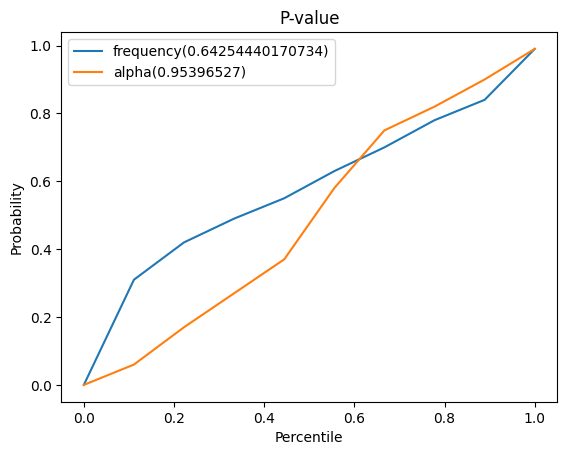

In [38]:
x=np.linspace(0,1,10)
labels=['frequency','alpha']
for i,label in enumerate(labels):
  y=[]
  for percentile in x:
    inside=0
    low=0.5-percentile/2
    high=0.5+percentile/2
    for result in loaded_samples:
      data=result['data']
      posterior=result['posterior']
      if data[i]>np.quantile(posterior,low) and data[i]<np.quantile(posterior,high):
        inside+=1
    y.append(inside/len(loaded_samples))    
  pvalue=scipy.stats.kstest(y,'uniform').pvalue  
  plt.plot(x,y,label=label+'('+ str(pvalue)+ ')')
  plt.xlabel('Percentile')  
  plt.ylabel('Probability')
  plt.title('P-value')
  print(scipy.stats.kstest(y,'uniform').pvalue)
plt.legend()    